In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import time
from tqdm import tqdm
from utils import*
import gc
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
points_c=get_file_obj("./data/dargon.obj")

In [3]:
print(points_c.shape)

torch.Size([100250, 6])


In [4]:
dico=dict()
bord=get_borders(points_c)

create_quadtree(dico,0,11,points_c,bord,"")

In [5]:
def get_min_width(dico,D):
    min_width=1e9
    for node in dico:
        if (dico[node][2]<min_width and dico[node][0]<=D ):
            min_width=dico[node][2]
    return min_width
        

def get_dico_final(dico,D):
    new_dico=dict()

    for node in dico:
        if dico[node][0]==D or (dico[node][0]<=D and len(dico[node][-1])==1):

            for i in range(1,9):
                tmp_node=node[:-1]+str(i)
                new_dico[tmp_node]=dico[tmp_node]
    return new_dico
        

def get_os(nb_s,dico,D):
    cpt_p=0
    s_p=torch.ones((nb_s,6))
    o_s=torch.ones((nb_s,8,5)) #interpolation weight , width , center
    for node in dico:
        if dico[node][0]==D or (dico[node][0]<=D and len(dico[node][-1])==1):
            depth,o_c,o_w,border,border_father,l_points=dico[node]

            for p in l_points:
                s_p[cpt_p]=p.clone()

                gx,dx,gy,dy,gz,dz=border_father

                tmp_o_vec=torch.empty((8,5))
                for idx_nbgr in range(1,9):
                    tmp_node=node[:-1]+str(idx_nbgr)
                    tmp_o_vec[idx_nbgr-1,1]=dico[tmp_node][2]
                    tmp_o_vec[idx_nbgr-1,2:]=dico[tmp_node][1]

                    

                    u=(s_p[cpt_p,0]-gx)/(dx-gx)
                    v=(s_p[cpt_p,1]-gy)/(dy-gy)
                    w=(s_p[cpt_p,2]-gz)/(dz-gz)
                    

                    
                    if idx_nbgr==1:
                        tmp_o_vec[0,0]=(1-u)*v*w
                    if idx_nbgr==2:
                        tmp_o_vec[1,0]=u*v*w
                    if idx_nbgr==3:
                        tmp_o_vec[2,0]=(1-u)*(1-v)*w
                    if idx_nbgr==4:
                        tmp_o_vec[3,0]=u*(1-v)*w
                    if idx_nbgr==5:
                        tmp_o_vec[4,0]=(1-u)*v*(1-w)
                    if idx_nbgr==6:
                        tmp_o_vec[5,0]=u*v*(1-w)
                    if idx_nbgr==7:
                        tmp_o_vec[6,0]=(1-u)*(1-v)*(1-w)
                    if idx_nbgr==8:
                        tmp_o_vec[7,0]=u*(1-v)*(1-w)
                        
                
                
                
                o_s[cpt_p]=tmp_o_vec.clone()
                cpt_p+=1
    return s_p,o_s


def get_os_opti(q,dico,D,distance_box):
    cpt_p=0
    s_p=torch.empty(0)
    o_s=torch.empty(0) #interpolation weight , width , center
    for node in dico:
        if dico[node][0]==D or (dico[node][0]<=D and len(dico[node][-1])==1):
            depth,o_c,o_w,border,border_father,l_points=dico[node]
            
            if torch.sqrt(torch.sum((o_c-q)**2))>(distance_box*1.5+o_w*8):
                continue

            for p in l_points:
                #s_p[cpt_p]=p.clone()
                s_p=torch.cat((s_p,p.clone().unsqueeze(0)),dim=0)
                

                gx,dx,gy,dy,gz,dz=border_father

                tmp_o_vec=torch.empty((1,8,5))
                for idx_nbgr in range(1,9):
                    tmp_node=node[:-1]+str(idx_nbgr)
                    tmp_o_vec[0,idx_nbgr-1,1]=dico[tmp_node][2]
                    tmp_o_vec[0,idx_nbgr-1,2:]=dico[tmp_node][1]

                    

                    u=(s_p[-1,0]-gx)/(dx-gx)
                    v=(s_p[-1,1]-gy)/(dy-gy)
                    w=(s_p[-1,2]-gz)/(dz-gz)
                    

                    
                    if idx_nbgr==1:
                        tmp_o_vec[0,0,0]=(1-u)*v*w
                    if idx_nbgr==2:
                        tmp_o_vec[0,1,0]=u*v*w
                    if idx_nbgr==3:
                        tmp_o_vec[0,2,0]=(1-u)*(1-v)*w
                    if idx_nbgr==4:
                        tmp_o_vec[0,3,0]=u*(1-v)*w
                    if idx_nbgr==5:
                        tmp_o_vec[0,4,0]=(1-u)*v*(1-w)
                    if idx_nbgr==6:
                        tmp_o_vec[0,5,0]=u*v*(1-w)
                    if idx_nbgr==7:
                        tmp_o_vec[0,6,0]=(1-u)*(1-v)*(1-w)
                    if idx_nbgr==8:
                        tmp_o_vec[0,7,0]=u*(1-v)*(1-w)
                        
                
                
                
                #o_s[cpt_p]=tmp_o_vec.clone()
                o_s=torch.cat((o_s,tmp_o_vec.clone()),dim=0)
                cpt_p+=1
    return s_p,o_s

def get_V_q(q,l_o,l_s):
    q_vec=torch.empty((l_o.shape[0],8,3))
    q_vec[:,:,0]=q[0]
    q_vec[:,:,1]=q[1]
    q_vec[:,:,2]=q[2]
    
    q_vec[:,:,0]-=l_o[:,:,2]
    q_vec[:,:,0]/=l_o[:,:,1]
    q_vec[:,:,1]-=l_o[:,:,3]
    q_vec[:,:,1]/=l_o[:,:,1]
    q_vec[:,:,2]-=l_o[:,:,4]
    q_vec[:,:,2]/=l_o[:,:,1]
    
    test=torch.exp(-torch.sum((q_vec)**2,dim=2)/(1.5**2))
    
    
    test=test*l_o[:,:,0]
    
    res=torch.empty((l_o.shape[0],8,3))
    res[:,0]=l_s[:,3:]
    res[:,1]=l_s[:,3:]
    res[:,2]=l_s[:,3:]
    res[:,3]=l_s[:,3:]
    res[:,4]=l_s[:,3:]
    res[:,5]=l_s[:,3:]
    res[:,6]=l_s[:,3:]
    res[:,7]=l_s[:,3:]

    res[:,0,0]*=test[:,0]
    res[:,0,1]*=test[:,0]
    res[:,0,2]*=test[:,0]
    res[:,1,0]*=test[:,1]
    res[:,1,1]*=test[:,1]
    res[:,1,2]*=test[:,1]
    res[:,2,0]*=test[:,2]
    res[:,2,1]*=test[:,2]
    res[:,2,2]*=test[:,2]
    res[:,3,0]*=test[:,3]
    res[:,3,1]*=test[:,3]
    res[:,3,2]*=test[:,3]
    res[:,4,0]*=test[:,4]
    res[:,4,1]*=test[:,4]
    res[:,4,2]*=test[:,4]
    res[:,5,0]*=test[:,5]
    res[:,5,1]*=test[:,5]
    res[:,5,2]*=test[:,5]
    res[:,6,0]*=test[:,6]
    res[:,6,1]*=test[:,6]
    res[:,6,2]*=test[:,6]
    res[:,7,0]*=test[:,7]
    res[:,7,1]*=test[:,7]
    res[:,7,2]*=test[:,7]
    
    res=torch.sum(res,dim=(0,1))
    
    return res

def get_V_tmp(coords_grid,l_o,l_s):
    #q [ r_x , r_y , r_z,  3 ]
    #     0    1     2    3

    q=coords_grid.clone().unsqueeze(3).unsqueeze(4).repeat(1,1,1,l_o.shape[0],8,1).to(device) 
    #q [ r_x , r_y , r_z, l_o , 8 , 3 ]
    #     0     1     2    3    4   5

    q[:,:,:,:,:,0]-=l_o[:,:,2]
    q[:,:,:,:,:,0]/=l_o[:,:,1]
    q[:,:,:,:,:,1]-=l_o[:,:,3]
    q[:,:,:,:,:,1]/=l_o[:,:,1]
    q[:,:,:,:,:,2]-=l_o[:,:,4]
    q[:,:,:,:,:,2]/=l_o[:,:,1]
    
    test=torch.exp(-torch.sum((q)**2,dim=5)/(1.5**2))
    
    
    test=test*l_o[:,:,0]
    

    res=l_s[:,3:].clone().unsqueeze(1).unsqueeze(0).unsqueeze(0).unsqueeze(0).to(device) 
    res=res.repeat(coords_grid.shape[0],coords_grid.shape[1],coords_grid.shape[2],1,8,1).to(device) 
    



    res[:,:,:,:,0,0]*=test[:,:,:,:,0]
    res[:,:,:,:,0,1]*=test[:,:,:,:,0]
    res[:,:,:,:,0,2]*=test[:,:,:,:,0]
    res[:,:,:,:,1,0]*=test[:,:,:,:,1]
    res[:,:,:,:,1,1]*=test[:,:,:,:,1]
    res[:,:,:,:,1,2]*=test[:,:,:,:,1]
    res[:,:,:,:,2,0]*=test[:,:,:,:,2]
    res[:,:,:,:,2,1]*=test[:,:,:,:,2]
    res[:,:,:,:,2,2]*=test[:,:,:,:,2]
    res[:,:,:,:,3,0]*=test[:,:,:,:,3]
    res[:,:,:,:,3,1]*=test[:,:,:,:,3]
    res[:,:,:,:,3,2]*=test[:,:,:,:,3]
    res[:,:,:,:,4,0]*=test[:,:,:,:,4]
    res[:,:,:,:,4,1]*=test[:,:,:,:,4]
    res[:,:,:,:,4,2]*=test[:,:,:,:,4]
    res[:,:,:,:,5,0]*=test[:,:,:,:,5]
    res[:,:,:,:,5,1]*=test[:,:,:,:,5]
    res[:,:,:,:,5,2]*=test[:,:,:,:,5]
    res[:,:,:,:,6,0]*=test[:,:,:,:,6]
    res[:,:,:,:,6,1]*=test[:,:,:,:,6]
    res[:,:,:,:,6,2]*=test[:,:,:,:,6]
    res[:,:,:,:,7,0]*=test[:,:,:,:,7]
    res[:,:,:,:,7,1]*=test[:,:,:,:,7]
    res[:,:,:,:,7,2]*=test[:,:,:,:,7]

    
    
    res=torch.sum(res,dim=(3,4)).to(device) 
   
    
    return res
    
    #q_vec=torch.where( (q_vec>=0)&(q_vec<100), )



In [6]:
#l_s,l_o=get_os(s_p.shape[0],dico,D)

def get_V_vec(points_c,dico,D,name="V.blp"):
    
    l_s,l_o=get_os(points_c.shape[0],dico,D)

    batch_size=32
    batch_size_grid=128

    min_x=torch.min(points_c[:,0]).item()
    max_x=torch.max(points_c[:,0]).item()
    min_y=torch.min(points_c[:,1]).item()
    max_y=torch.max(points_c[:,1]).item()
    min_z=torch.min(points_c[:,2]).item()
    max_z=torch.max(points_c[:,2]).item()
    resolution=64
    
    x_range=torch.linspace(min_x,max_x,resolution)
    y_range=torch.linspace(min_y,max_y,resolution)
    z_range=torch.linspace(min_z,max_z,resolution)

    grid_coords=torch.zeros((resolution,resolution,resolution,3))
    grid_res=torch.zeros((resolution,resolution,resolution,3))

    grid_x, grid_y, grid_z = torch.meshgrid(x_range, y_range, z_range, indexing='ij')

    grid_coords[:,:,:,0]=grid_x
    grid_coords[:,:,:,1]=grid_y
    grid_coords[:,:,:,2]=grid_z

    

    
    for batch_samples in tqdm(range(0,l_o.shape[0],batch_size)):

        tmp_l_s=l_s[batch_samples:batch_samples+batch_size].to(device) 
        tmp_l_o=l_o[batch_samples:batch_samples+batch_size].to(device) 

        for u in (range(0,grid_coords.shape[0],batch_size_grid)):
            for v in (range(0,grid_coords.shape[1],batch_size_grid)):
                for w in range(0,grid_coords.shape[2],batch_size_grid):
        
                    #start_time = time.time()
                    tmp_grid=grid_coords[u:u+batch_size_grid,v:v+batch_size_grid,w:w+batch_size_grid].to(device)
                    grid_res[u:u+batch_size_grid,v:v+batch_size_grid,w:w+batch_size_grid]+=get_V_tmp(tmp_grid,tmp_l_o,tmp_l_s).detach().cpu()
                    #end_time = time.time()
                    #print("---Computation time %s seconds ---" % (np.around(end_time - start_time,5)),"   ",l_o.shape)

    np.save(name,grid_res.numpy().astype(np.single))
    torch.cuda.empty_cache()
    gc.collect()
    

    
start_time = time.time()    
get_V_vec(points_c,dico,D=5,name="V.npy")   
end_time = time.time()


100%|██████████| 3133/3133 [02:32<00:00, 20.52it/s]


In [32]:
values = np.load("./V_dragon_6_256.npy")
values=torch.from_numpy(values)

In [33]:
def compute_divergence(V):
    # Initialize the divergence tensor with the same spatial dimensions, but only one channel
    div_V = torch.zeros((V.shape[0], V.shape[1], V.shape[2]))
    
    # Compute the x-component of the divergence using central differences
    # For the borders, you can use forward or backward differences
    div_V[1:-1, :,:] += (V[2:, :,:, 0] - V[:-2, :,:, 0]) / 2
    
    # Compute the y-component of the divergence using central differences
    # For the borders, you can use forward or backward differences
    div_V[:, 1:-1,:] += (V[:, 2:,:, 1] - V[:, :-2,:, 1]) / 2
    div_V[:, :,1:-1] += (V[:,: ,2:, 2] - V[:, :, :-2, 2]) / 2
    
    
    # Handle the borders if necessary (here we assume a zero-gradient boundary condition)
    # This can be replaced with a more appropriate condition for your specific case
    div_V[0, :,:] += (V[1, :,:, 0] - V[0, :,:, 0])
    div_V[-1, :,:] += (V[-1, :,:, 0] - V[-2, :,:, 0])
    div_V[:, 0,:] += (V[:, 1,:, 1] - V[:, 0,:, 1])
    div_V[:, -1,:] += (V[:, -1,:, 1] - V[:, -2,:, 1])
    div_V[:,:, 0] += (V[:, :,1, 1] - V[:,:, 0, 1])
    div_V[:,:, -1] += (V[:, :,-1, 1] - V[:,:, -2, 1])

    return div_V

    

In [34]:
grad=compute_divergence(values)
print(grad.shape)

torch.Size([256, 256, 256])


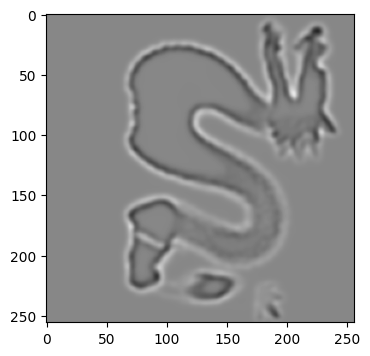

In [36]:
fig = plt.figure(figsize=plt.figaspect(0.25))
slice=128
ax = fig.add_subplot(1, 1, 1)
plt.imshow(grad[:,:,slice],cmap="gray",vmin=torch.min(grad),vmax=torch.max(grad))


#plt.quiver(X_plot,Y_plot,values[:,:,slice,0],values[:,:,slice,1],alpha = 0.5,scale = 0.1)


In [37]:


def get_list_gaussians(borders,D):
    res_centers=torch.empty(8**D,4)
    borders=get_borders(points_c)

    min_x=borders[0].item()
    max_x=borders[1].item()
    min_y=borders[2].item()
    max_y=borders[3].item()
    min_z=borders[4].item()
    max_z=borders[5].item()

    Width=(max_x-min_x)/(2**D)
    cpt_idx=0

    for i in tqdm(range(2**D)):
        for j in range(2**D):
            for w in range(2**D):
            
                xa=min_x+(i*Width)+Width/2.0
                ya=min_y+(j*Width)+Width/2.0
                za=min_z+(w*Width)+Width/2.0
        
                res_centers[cpt_idx,0]=xa
                res_centers[cpt_idx,1]=ya
                res_centers[cpt_idx,2]=za
                res_centers[cpt_idx,3]=Width
                
                cpt_idx+=1
    return res_centers

In [38]:
bord=get_borders(points_c)
L_gaussians=get_list_gaussians(bord,5)
print(L_gaussians.shape)

100%|██████████| 32/32 [00:00<00:00, 52.38it/s]

torch.Size([32768, 4])


In [41]:
def get_inner_product_gradVB(V,L_gaussians,borders):
    res=torch.empty(L_gaussians.shape[0])

    min_x=torch.min(points_c[:,0]).item()
    max_x=torch.max(points_c[:,0]).item()
    min_y=torch.min(points_c[:,1]).item()
    max_y=torch.max(points_c[:,1]).item()
    min_z=torch.min(points_c[:,2]).item()
    max_z=torch.max(points_c[:,2]).item()

    resolution=256
    
    x_range=torch.linspace(min_x,max_x,resolution)
    y_range=torch.linspace(min_y,max_y,resolution)
    z_range=torch.linspace(min_z,max_z,resolution)
    
    
    grid_coords=torch.zeros((resolution,resolution,resolution,3))
    

    grid_x, grid_y, grid_z = torch.meshgrid(x_range, y_range, z_range, indexing='ij')

    grid_coords[:,:,:,0]=grid_x
    grid_coords[:,:,:,1]=grid_y
    grid_coords[:,:,:,2]=grid_z

    
    


    for idx_gaussian in tqdm(range(L_gaussians.shape[0])):
        tmp_res=grid_coords.clone()
        tmp_sum_g=(tmp_res[:,:,:,0]-L_gaussians[idx_gaussian,0])**2
        tmp_sum_g+=(tmp_res[:,:,:,1]-L_gaussians[idx_gaussian,1])**2
        tmp_sum_g+=(tmp_res[:,:,:,2]-L_gaussians[idx_gaussian,2])**2
        
        tmp_sum_g=torch.exp(-(tmp_sum_g/(2*L_gaussians[idx_gaussian,3]**2)))
        
        tmp_sum_g=tmp_sum_g*V*(2*L_gaussians[idx_gaussian,3]**2)
        tmp_sum_g=torch.sum(tmp_sum_g)
        res[idx_gaussian]=tmp_sum_g

    torch.cuda.empty_cache()
    gc.collect()
        
    
    
        
    return res

def get_inner_product_gradVB_new(V,L_gaussians,borders):
    V=V.to(device) 
    L_gaussians=L_gaussians.to(device) 

    
    
    res=torch.empty(L_gaussians.shape[0])

    min_x=torch.min(points_c[:,0]).item()
    max_x=torch.max(points_c[:,0]).item()
    min_y=torch.min(points_c[:,1]).item()
    max_y=torch.max(points_c[:,1]).item()
    min_z=torch.min(points_c[:,2]).item()
    max_z=torch.max(points_c[:,2]).item()

    resolution=V.shape[0]
    
    x_range=torch.linspace(min_x,max_x,resolution)
    y_range=torch.linspace(min_y,max_y,resolution)
    z_range=torch.linspace(min_z,max_z,resolution)
    
    
    grid_coords=torch.zeros((resolution,resolution,resolution,3)).to(device) 
    

    grid_x, grid_y, grid_z = torch.meshgrid(x_range, y_range, z_range, indexing='ij')

    grid_coords[:,:,:,0]=grid_x
    grid_coords[:,:,:,1]=grid_y
    grid_coords[:,:,:,2]=grid_z

    
    


    for idx_gaussian in tqdm(range(L_gaussians.shape[0])):
        
        tmp_sum_g=(grid_coords[:,:,:,0]-L_gaussians[idx_gaussian,0])**2
        tmp_sum_g+=(grid_coords[:,:,:,1]-L_gaussians[idx_gaussian,1])**2
        tmp_sum_g+=(grid_coords[:,:,:,2]-L_gaussians[idx_gaussian,2])**2
        
        tmp_sum_g=torch.exp(-(tmp_sum_g/(2*L_gaussians[idx_gaussian,3]**2)))
        
        tmp_sum_g=tmp_sum_g*V*(2*L_gaussians[idx_gaussian,3]**2)
        tmp_sum_g=torch.sum(tmp_sum_g)
        res[idx_gaussian]=tmp_sum_g.detach().cpu()

    V=V.detach().cpu()
    L_gaussians=L_gaussians.detach().cpu()
    torch.cuda.empty_cache()
    gc.collect()
        
    
    
        
    return res

In [42]:
#V_o=get_inner_product_gradVB(grad,L_gaussians,bord)
V_o=get_inner_product_gradVB_new(grad,L_gaussians,bord)

100%|██████████| 32768/32768 [01:26<00:00, 380.00it/s]


In [48]:
def get_indexes_BB(D):
    res=[]
    cpt=0
    for i in range(0,8**D,2**D):
        res.append(i)
        res.append(i+1)
        res.append(i+2)
        res.append(i+3)
        
        cpt+=1
        if cpt>=(2**D)*4:
            break
    return res

def get_inner_product_gradB_B(size_grid, L_gaussians, borders):
    
    res = torch.zeros((L_gaussians.shape[0], L_gaussians.shape[0]))


    batch_size=min(L_gaussians.shape[0],256)

    min_x=torch.min(points_c[:,0]).item()
    max_x=torch.max(points_c[:,0]).item()
    min_y=torch.min(points_c[:,1]).item()
    max_y=torch.max(points_c[:,1]).item()
    min_z=torch.min(points_c[:,2]).item()
    max_z=torch.max(points_c[:,2]).item()

    width_x = max_x - min_x
    width_y = max_y - min_y
    width_z = max_z - min_z

    xs = torch.linspace(min_x - width_x * 0.125, max_x + width_x * 0.125, steps=size_grid)
    ys = torch.linspace(min_y - width_y * 0.125, max_y + width_y * 0.125, steps=size_grid)
    zs = torch.linspace(min_z - width_z * 0.125, max_z + width_z * 0.125, steps=size_grid)
    
    x, y, z = torch.meshgrid(xs, ys, zs, indexing='xy')

    grid = torch.empty(size_grid, size_grid, size_grid, 3)
    grid[:, :, :, 0] = x
    grid[:, :, :, 1] = y
    grid[:, :, :, 2] = z
    
    cpt_economies=0

    for idx_gaussian_1 in tqdm(range(L_gaussians.shape[0])):
        cpt_eco=0
        for idx_gaussian_2 in range(idx_gaussian_1, L_gaussians.shape[0], batch_size):
            batch_end = min(idx_gaussian_2 + batch_size, L_gaussians.shape[0])
            taille_tmp = batch_end - idx_gaussian_2

            tmp_args_g1=L_gaussians[idx_gaussian_1].to(device) 
            tmp_g1 = grid.clone().to(device).unsqueeze(0).repeat((taille_tmp, 1, 1, 1, 1))
            tmp_g1 = torch.exp(-((tmp_g1[:,:,:,:,0] - tmp_args_g1[0])**2 + (tmp_g1[:,:,:,:,1] - tmp_args_g1[1])**2+(tmp_g1[:,:,:,:,2] - tmp_args_g1[2])**2) / (2 * tmp_args_g1[3]**2))

            tmp_g2 = grid.clone().to(device).unsqueeze(0).repeat((taille_tmp, 1, 1, 1, 1))
    
            L_gaussian_0_vec = L_gaussians[idx_gaussian_2:batch_end, 0].view((taille_tmp, 1, 1, 1)).repeat((1,tmp_g2.shape[-2], tmp_g2.shape[-2], tmp_g2.shape[-2])).to(device) 
            L_gaussian_1_vec = L_gaussians[idx_gaussian_2:batch_end, 1].view((taille_tmp, 1, 1, 1)).repeat((1,tmp_g2.shape[-2], tmp_g2.shape[-2], tmp_g2.shape[-2])).to(device) 
            L_gaussian_2_vec = L_gaussians[idx_gaussian_2:batch_end, 2].view((taille_tmp, 1, 1, 1)).repeat((1,tmp_g2.shape[-2], tmp_g2.shape[-2], tmp_g2.shape[-2])).to(device) 
            L_gaussian_3_vec = L_gaussians[idx_gaussian_2:batch_end, 3].view((taille_tmp, 1, 1, 1)).repeat((1,tmp_g2.shape[-2], tmp_g2.shape[-2], tmp_g2.shape[-2])).to(device) 
            
            fac_x = ((tmp_g2[:,:,:,:,0] - L_gaussian_0_vec)**2 - (L_gaussian_3_vec**2)) / (L_gaussian_3_vec**4)
            fac_y = ((tmp_g2[:,:,:,:,1] - L_gaussian_1_vec)**2 - (L_gaussian_3_vec**2)) / (L_gaussian_3_vec**4)
            fac_z = ((tmp_g2[:,:,:,:,2] - L_gaussian_2_vec)**2 - (L_gaussian_3_vec**2)) / (L_gaussian_3_vec**4)

            map_g2 = torch.exp(-((tmp_g2[:,:,:,:,0] - L_gaussian_0_vec)**2 + (tmp_g2[:,:,:,:,1] - L_gaussian_1_vec)**2 + (tmp_g2[:,:,:,:,2] - L_gaussian_2_vec)**2) / (2 * L_gaussian_3_vec**2)).to(device) 
            tmp_g2[:,:,:,:,0] = fac_x * map_g2
            tmp_g2[:,:,:,:,1] = fac_y * map_g2
            tmp_g2[:,:,:,:,2] = fac_z * map_g2

            tmp_res = torch.sum(tmp_g1 * tmp_g2[:,:,:,:,0] * (L_gaussian_3_vec**2)/(size_grid**2), dim=[1, 2, 3]) 
            tmp_res += torch.sum(tmp_g1 * tmp_g2[:,:,:,:,1] * (L_gaussian_3_vec**2)/(size_grid**2), dim=[1, 2, 3])
            tmp_res += torch.sum(tmp_g1 * tmp_g2[:,:,:,:,2] * (L_gaussian_3_vec**2)/(size_grid**2), dim=[1, 2, 3])
           
            res[idx_gaussian_1, idx_gaussian_2:batch_end] = tmp_res.detach().cpu()

    

    res = res + res.T - torch.diag(res.diagonal())

    
    return res





def get_inner_product_gradB_B_sparse(size_grid, L_gaussians, borders,D):
    
    sparse_indexes = torch.empty((2,0))
    sparse_values  = torch.empty(0)

    l_indexes=torch.from_numpy( np.array(get_indexes_BB(D)))
    print(l_indexes)

    batch_size=1024



    min_x=torch.min(points_c[:,0]).item()
    max_x=torch.max(points_c[:,0]).item()
    min_y=torch.min(points_c[:,1]).item()
    max_y=torch.max(points_c[:,1]).item()
    min_z=torch.min(points_c[:,2]).item()
    max_z=torch.max(points_c[:,2]).item()

    width_x = max_x - min_x
    width_y = max_y - min_y
    width_z = max_z - min_z

    xs = torch.linspace(min_x - width_x * 0.125, max_x + width_x * 0.125, steps=size_grid)
    ys = torch.linspace(min_y - width_y * 0.125, max_y + width_y * 0.125, steps=size_grid)
    zs = torch.linspace(min_z - width_z * 0.125, max_z + width_z * 0.125, steps=size_grid)
    
    x, y, z = torch.meshgrid(xs, ys, zs, indexing='xy')

    grid = torch.empty(size_grid, size_grid, size_grid, 3)
    grid[:, :, :, 0] = x
    grid[:, :, :, 1] = y
    grid[:, :, :, 2] = z
    

    for idx_gaussian_1 in tqdm(range(L_gaussians.shape[0])):
        
        for idx_gaussian_2 in range(0, len(l_indexes)-batch_size,batch_size):
            
            idxs_2=idx_gaussian_1+l_indexes[idx_gaussian_2:idx_gaussian_2+min(batch_size,L_gaussians.shape[0]-idx_gaussian_2)]
            
            idxs_2=idxs_2[idxs_2<L_gaussians.shape[0]]
            taille_tmp = idxs_2.shape[0]
            
            

            tmp_args_g1=L_gaussians[idx_gaussian_1].to(device) 
            tmp_g1 = grid.clone().to(device).unsqueeze(0).repeat((taille_tmp, 1, 1, 1, 1))
            tmp_g1 = torch.exp(-((tmp_g1[:,:,:,:,0] - tmp_args_g1[0])**2 + (tmp_g1[:,:,:,:,1] - tmp_args_g1[1])**2+(tmp_g1[:,:,:,:,2] - tmp_args_g1[2])**2) / (2 * tmp_args_g1[3]**2))

            tmp_g2 = grid.clone().to(device).unsqueeze(0).repeat((taille_tmp, 1, 1, 1, 1))
    
            L_gaussian_0_vec = L_gaussians[idxs_2, 0].view((taille_tmp, 1, 1, 1)).repeat((1,tmp_g2.shape[-2], tmp_g2.shape[-2], tmp_g2.shape[-2])).to(device) 
            L_gaussian_1_vec = L_gaussians[idxs_2, 1].view((taille_tmp, 1, 1, 1)).repeat((1,tmp_g2.shape[-2], tmp_g2.shape[-2], tmp_g2.shape[-2])).to(device) 
            L_gaussian_2_vec = L_gaussians[idxs_2, 2].view((taille_tmp, 1, 1, 1)).repeat((1,tmp_g2.shape[-2], tmp_g2.shape[-2], tmp_g2.shape[-2])).to(device) 
            L_gaussian_3_vec = L_gaussians[idxs_2, 3].view((taille_tmp, 1, 1, 1)).repeat((1,tmp_g2.shape[-2], tmp_g2.shape[-2], tmp_g2.shape[-2])).to(device) 
            
            fac_x = ((tmp_g2[:,:,:,:,0] - L_gaussian_0_vec)**2 - (L_gaussian_3_vec**2)) / (L_gaussian_3_vec**4)
            fac_y = ((tmp_g2[:,:,:,:,1] - L_gaussian_1_vec)**2 - (L_gaussian_3_vec**2)) / (L_gaussian_3_vec**4)
            fac_z = ((tmp_g2[:,:,:,:,2] - L_gaussian_2_vec)**2 - (L_gaussian_3_vec**2)) / (L_gaussian_3_vec**4)

            map_g2 = torch.exp(-((tmp_g2[:,:,:,:,0] - L_gaussian_0_vec)**2 + (tmp_g2[:,:,:,:,1] - L_gaussian_1_vec)**2 + (tmp_g2[:,:,:,:,2] - L_gaussian_2_vec)**2) / (2 * L_gaussian_3_vec**2)).to(device) 
            tmp_g2[:,:,:,:,0] = fac_x * map_g2
            tmp_g2[:,:,:,:,1] = fac_y * map_g2
            tmp_g2[:,:,:,:,2] = fac_z * map_g2

            tmp_res = torch.sum(tmp_g1 * tmp_g2[:,:,:,:,0] * (L_gaussian_3_vec**2)/(size_grid**2), dim=[1, 2, 3])
            tmp_res += torch.sum(tmp_g1 * tmp_g2[:,:,:,:,1] * (L_gaussian_3_vec**2/(size_grid**2)), dim=[1, 2, 3])
            tmp_res += torch.sum(tmp_g1 * tmp_g2[:,:,:,:,2] * (L_gaussian_3_vec**2/(size_grid**2)), dim=[1, 2, 3])

            if torch.sum(torch.abs(tmp_res))<1e-4:
                break

            #tmp_res.shape : batch_size
            for idx_case in range(tmp_res.shape[0]):
                if torch.abs(tmp_res[idx_case]) > 1e-4:
                    
                    idx_i = idx_gaussian_1
                    idx_j = idxs_2[idx_case]
                    
                    # Upper triangular part
                    sparse_indexes = torch.cat((sparse_indexes, torch.tensor([[idx_i], [idx_j]])), dim=1)
                    sparse_values = torch.cat((sparse_values, torch.tensor([tmp_res[idx_case].detach().cpu()])), dim=0)
            
                    # Check to avoid adding diagonal elements twice
                    if idx_i != idx_j:
                        # Lower triangular part (symmetric element)
                        sparse_indexes = torch.cat((sparse_indexes, torch.tensor([[idx_j], [idx_i]])), dim=1)
                        sparse_values = torch.cat((sparse_values, torch.tensor([tmp_res[idx_case].detach().cpu()])), dim=0)

               
                    
    #np.save("./L_oo/indexes_"+str(D)+".npy",sparse_indexes.numpy().astype(np.single))
    #np.save("./L_oo/values_"+str(D)+".npy",sparse_values.numpy().astype(np.single))
    torch.cuda.empty_cache()
    gc.collect()
    
    return torch.sparse_coo_tensor(sparse_indexes, sparse_values,size=(8**D, 8**D))














In [49]:
#L_oo=get_inner_product_gradB_B(grad.shape[0],L_gaussians,bord)
L_gaussians=L_gaussians.detach().cpu()
L_oo=get_inner_product_gradB_B_sparse(8,L_gaussians,bord,5)
print(L_oo.shape)

tensor([   0,    1,    2,    3,   32,   33,   34,   35,   64,   65,   66,   67,
          96,   97,   98,   99,  128,  129,  130,  131,  160,  161,  162,  163,
         192,  193,  194,  195,  224,  225,  226,  227,  256,  257,  258,  259,
         288,  289,  290,  291,  320,  321,  322,  323,  352,  353,  354,  355,
         384,  385,  386,  387,  416,  417,  418,  419,  448,  449,  450,  451,
         480,  481,  482,  483,  512,  513,  514,  515,  544,  545,  546,  547,
         576,  577,  578,  579,  608,  609,  610,  611,  640,  641,  642,  643,
         672,  673,  674,  675,  704,  705,  706,  707,  736,  737,  738,  739,
         768,  769,  770,  771,  800,  801,  802,  803,  832,  833,  834,  835,
         864,  865,  866,  867,  896,  897,  898,  899,  928,  929,  930,  931,
         960,  961,  962,  963,  992,  993,  994,  995, 1024, 1025, 1026, 1027,
        1056, 1057, 1058, 1059, 1088, 1089, 1090, 1091, 1120, 1121, 1122, 1123,
        1152, 1153, 1154, 1155, 1184, 11

100%|██████████| 32768/32768 [00:00<00:00, 944279.61it/s]


torch.Size([32768, 32768])


In [50]:

#print(L_oo.shape)
#plt.imshow(L_oo.to_dense(),interpolation="none")
#plt.colorbar()

In [51]:
import torch.optim as optim

def grad_loss(L,img,V):
    return torch.sqrt(torch.mean((torch.sparse.mm(L,img.view((img.shape[0],1)))-V.view((V.shape[0],1)))**2))


def fit(L,V):
    optimizer=optim.LBFGS([torch.zeros(0)],lr=1e-3, max_iter=100)
    eps_b=V.clone()#torch.randn(V.shape)
    eps_b.requires_grad = True
    optimizer.param_groups[0]['params'][0] = eps_b

    def closure():
        optimizer.zero_grad()
        loss=grad_loss(L,eps_b,V)
        loss.backward(retain_graph=True)
        return loss
    loss=optimizer.step(closure)
    print(loss)
    
    return eps_b

eps=fit(L_oo,V_o)

eps=eps.detach()
print(eps.shape)

tensor(1.2502, grad_fn=<SqrtBackward0>)
torch.Size([32768])


In [58]:
#grid resolution
n_p=256

min_x=torch.min(points_c[:,0]).item()
max_x=torch.max(points_c[:,0]).item()
min_y=torch.min(points_c[:,1]).item()
max_y=torch.max(points_c[:,1]).item()
min_z=torch.min(points_c[:,2]).item()
max_z=torch.max(points_c[:,2]).item()

width_x=max_x-min_x
width_y=max_y-min_y
width_z=max_y-min_z

image_res=torch.zeros((n_p,n_p,n_p))

xs = torch.linspace(min_x - width_x * 0.125, max_x + width_x * 0.125, steps=n_p)
ys = torch.linspace(min_y - width_y * 0.125, max_y + width_y * 0.125, steps=n_p)
zs = torch.linspace(min_z - width_z * 0.125, max_z + width_z * 0.125, steps=n_p)

x, y, z = torch.meshgrid(xs, ys, zs, indexing='xy')

grid = torch.empty(n_p, n_p, n_p, 3)
grid[:, :, :, 0] = x
grid[:, :, :, 1] = y
grid[:, :, :, 2] = z


def get_X(x,l_g,q):
    res=torch.sum(torch.exp(-((q[0] - l_g[:,0])**2 + (q[1] - l_g[:,1])**2 + (q[2] - l_g[:,2])**2 ) / (l_g[0,3] * 2)**2)*x)

    return res
        


L_gaussians=L_gaussians.to(device) 
eps=eps.to(device) 


for i in tqdm(range(xs.shape[0])):
    for j in range(xs.shape[0]):
        #for w in range(xs.shape[0]):
        w=128
        image_res[i,j,w]=get_X(eps,L_gaussians,grid[i,j,w].to(device) ).detach().cpu()

100%|██████████| 256/256 [00:11<00:00, 21.82it/s]


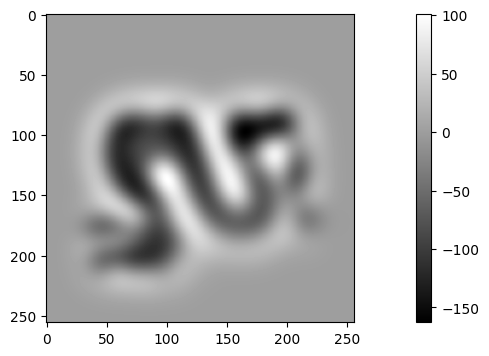

In [59]:
fig = plt.figure(figsize=plt.figaspect(0.25))
slice=128
ax = fig.add_subplot(1, 1, 1)
plt.imshow(image_res[:,:,slice],cmap="gray")
plt.colorbar()


#plt.quiver(X_plot,Y_plot,values[:,:,slice,0],values[:,:,slice,1],alpha = 0.5,scale = 0.1)
#print(image_res[60,60,64])

In [21]:
 def get_isovalue(eps,l_g,l_p):
     res=torch.zeros(l_p.shape)
     for idx_p in tqdm(range(l_p.shape[0])):
         tmp_p=l_p[idx_p,:3]
         res[idx_p]=get_X(eps,l_g,tmp_p)
     return res.mean()

In [22]:
iso_val=get_isovalue(eps,L_gaussians,points_c)
print(iso_val)

100%|██████████| 100250/100250 [00:15<00:00, 6333.21it/s]

tensor(-11.5583)


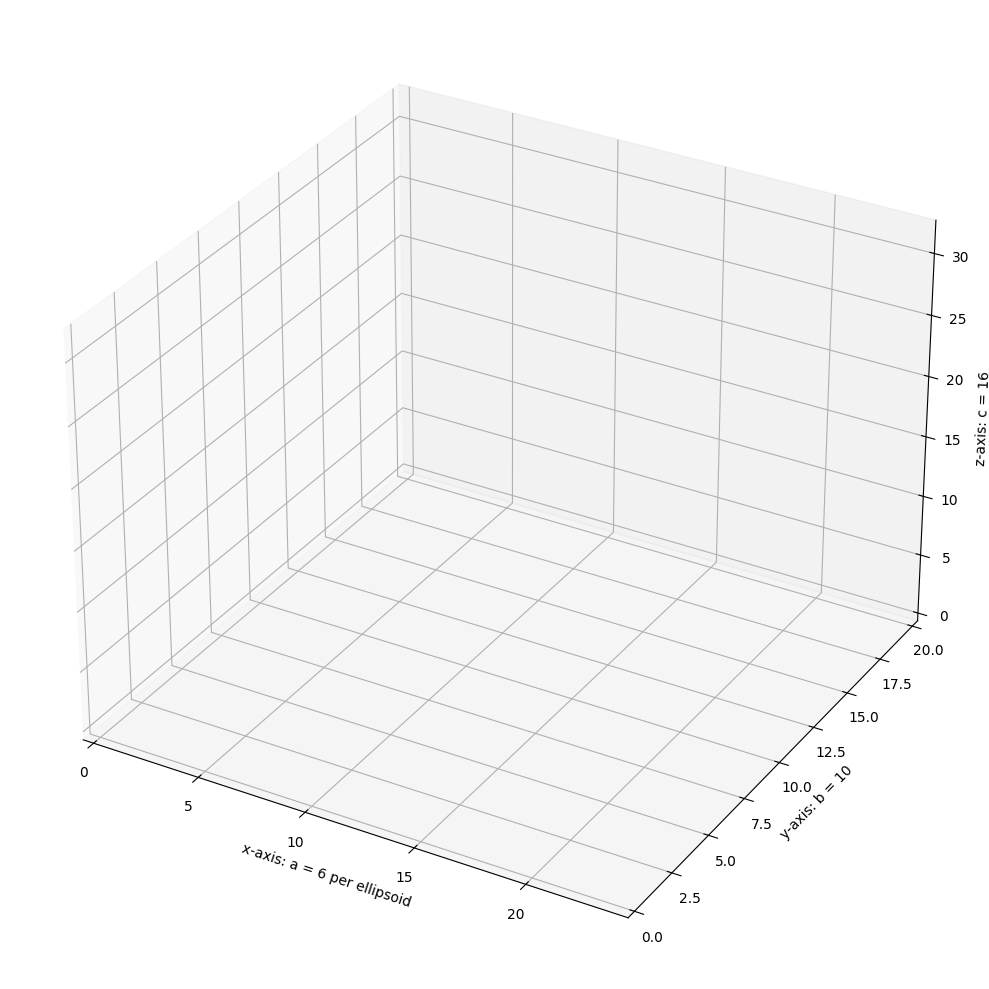

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from skimage import measure
from skimage.draw import ellipsoid




# Use marching cubes to obtain the surface mesh of these ellipsoids
verts, faces, normals, values = measure.marching_cubes(image_res.numpy())

# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes docstring).
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

ax.set_xlabel("x-axis: a = 6 per ellipsoid")
ax.set_ylabel("y-axis: b = 10")
ax.set_zlabel("z-axis: c = 16")

ax.set_xlim(0, 24)  # a = 6 (times two for 2nd ellipsoid)
ax.set_ylim(0, 20)  # b = 10
ax.set_zlim(0, 32)  # c = 16

plt.tight_layout()
plt.show()


In [24]:
print(image_res.min())

tensor(-23.7961)


In [25]:
tmp=torch.linspace(1,100,100)
print(tmp.shape)
print(tmp.view((100,1)).shape)

torch.Size([100])
torch.Size([100, 1])


In [26]:
tmp_test_cat=torch.empty((0))
a=torch.empty((1))
a[0]=1


tmp_test_cat=torch.cat((tmp_test_cat,a),dim=0)
tmp_test_cat=torch.cat((tmp_test_cat,a),dim=0)
tmp_test_cat=torch.cat((tmp_test_cat,a),dim=0)
print(tmp_test_cat)

tensor([1., 1., 1.])
